### 1.1 Load packages

In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# miscellaneous
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# deep learning stack
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

In [2]:
# tensorflow and keras version
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

TensorFlow version: 2.11.0
Keras version: 2.11.0


In [3]:
from tensorflow.keras.applications.resnet50  import (
    ResNet50,
    preprocess_input,
    decode_predictions
)

### 1.2 User-defined functions

In [4]:
def load_image(image_path):
    """
    loads an input image into PIL format of size 224 X 224
    """
    img = image.load_img(
        path=image_path,
        target_size=(224,224)
    )
    return img

In [5]:
def batch_image(loaded_image):
    """
    converts a loaded image to a batch
    """
    img_array = image.img_to_array(loaded_image)
    img_batch = np.array([img_array])
    
    return img_batch

In [6]:
def preprocess_image(batched_image):
    """
    preprocesses a batch image to make suitable for resnet50
    """
    processed_img = preprocess_input(batched_image)
    
    return processed_img

In [7]:
def show_preprocess_image(image_path):
    """
    shows loaded image given an image path, and
    preprocesses it to make suitable for mobilenet_v2
    """
    # load resized image
    loaded_img = load_image(image_path)
    
    # display image
    plt.figure(figsize=(3,3), dpi=100)
    plt.imshow(loaded_img)
    
    # create batched image
    batch_img = batch_image(loaded_img)
    
    # preprocess image
    processed_img = preprocess_image(batch_img)
    
    return processed_img

In [8]:
def image_class_prediction(model, preprocessed_image):
    """
    spits out the top-5 predictions of a given model with a proprocessed image
    """
    model_prediction = model.predict(preprocessed_image,verbose=0)
    decoded_prediction = decode_predictions(model_prediction,top=5)[0]
    data = {
        'image_class': [_[1] for _ in decoded_prediction],
        'probability': [_[2] for _ in decoded_prediction]
    }
    df = pd.DataFrame(data=data)
    return df

**image classes**

In [9]:
CLASSES = os.listdir('training_data')
CLASSES

['buildings', 'sea', 'street', 'forest', 'mountain', 'glacier']

<hr style="border:2px solid black">

## 2. Transfer Learning Example

[**getting training images into keras**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [10]:
# instantiate image data generator

data_gen = image.ImageDataGenerator(
    # preprocessing function for all images
    preprocessing_function=preprocess_input
)

In [11]:
# generate batches of x and y arrays from directory

train_data_gen = data_gen.flow_from_directory(
        directory='training_data',
        class_mode="categorical",
        classes=CLASSES,
        batch_size=600,
        target_size=(224,224)
)

Found 600 images belonging to 6 classes.


In [12]:
# load in all images at once

xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((600, 224, 224, 3), (600, 6))

### 2.1 Model Building 

**2.1.1 Select convolutional base with frozen weights**

In [13]:
# define base model

BASE_MODEL = ResNet50(
    weights='imagenet', 
    include_top=False,  # removal of final dense layers
    pooling='avg',      # average pooling to last convolutional layer's ouput
    input_shape=(224,224,3) # ignored if input tensor is provided
)

94765736/94765736 [==============================] - 13s 0us/step


In [14]:
# freeze base model
BASE_MODEL.trainable = False

In [15]:
# base model summary
BASE_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

**3.1.2 Add dense layers on top**

In [16]:
def BuildModel():
    '''
    complies a model by stacking dense layers on top of base model 
    '''
    # initialize the Sequential API to stack the layers
    model = keras.Sequential()
    
    # convolutional base 
    model.add(BASE_MODEL)
    
    # first dense layer
    model.add(
        keras.layers.Dense(
            units=160, 
            activation='relu'
        )
    )
    # dropout 
    model.add(
        keras.layers.Dropout(
            rate=0.5
        )
    )
    # output layer with softmax activation function
    model.add(
        keras.layers.Dense(
            len(CLASSES),
            activation='softmax'
        )
    )
    # compile model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy]
    )

    return model

### 2.3 Model Training

**train model**

In [17]:
# instantiate model
model = BuildModel()

In [18]:
# early stopping

stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5
)

In [19]:
model.fit(
    xtrain,
    ytrain,
    epochs=50,
    batch_size=30,
    callbacks=[stop_early],
    validation_split=0.2
)

Epoch 1/50
 6/16 [==========>...................] - ETA: 24s - loss: 1.6440 - categorical_accuracy: 0.4278

KeyboardInterrupt: 

**training history: losses and epoch numbers**

In [20]:
# losses in the training history
losses = pd.DataFrame(model.history.history)
# training loss
loss = losses['loss'].values 
# validation loss
val_loss = losses['val_loss'].values

# epoch number
epoch = losses.index.values + np.ones_like(losses.index.values)

**plot training history**

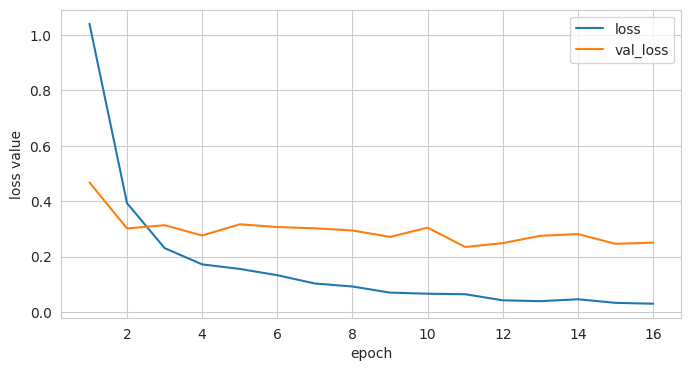

In [21]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,4),dpi=100)
plt.plot(epoch, loss, linewidth=1.5, label='loss')
plt.plot(epoch, val_loss, linewidth=1.5, label='val_loss')

plt.xlabel('epoch',fontsize=10)
plt.ylabel('loss value',fontsize=10)
plt.legend(loc=1,fontsize=10);

### 2.4 Model Evaluation

In [25]:
def image_predict(preprocessed_image, model):
    """
    returns class probabilities for a given image,
    based on the model obtained via transfer learning 
    """
    probabilities = model.predict(
        preprocessed_image,
        verbose=0
    )
    probabilities = np.round(probabilities,6)[0]
    class_probabilities = dict(zip(CLASSES,probabilities))
    
    return class_probabilities

**sea image**

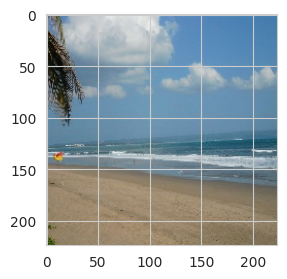

In [26]:
# show and preprocess image
test_image1 = show_preprocess_image('test_images/Bali/3497160339.jpg')

In [27]:
# predict image class
image_predict(test_image1, model)

{'glacier': 3e-06,
 'street': 2e-06,
 'buildings': 0.0,
 'forest': 4e-06,
 'mountain': 2e-06,
 'sea': 0.999989}

**street image**

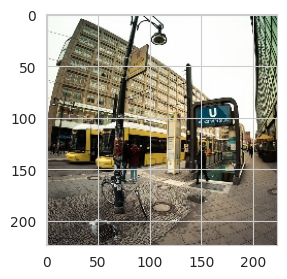

In [28]:
# show and preprocess image
test_image2 = show_preprocess_image('test_images/Berlin/48666209121.jpg')

In [29]:
# predict image class
image_predict(test_image2, model)

{'glacier': 0.000176,
 'street': 0.952088,
 'buildings': 0.046946,
 'forest': 8.5e-05,
 'mountain': 2.2e-05,
 'sea': 0.000684}

**mountain image**

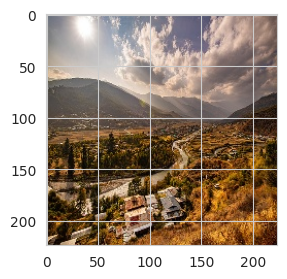

In [30]:
# show and preprocess image
test_image3 = show_preprocess_image('test_images/Bhutan/49836747892.jpg')

In [31]:
# predict image class
image_predict(test_image3, model)

{'glacier': 0.000356,
 'street': 2.9e-05,
 'buildings': 0.001047,
 'forest': 0.000293,
 'mountain': 0.998236,
 'sea': 3.8e-05}

<hr style="border:2px solid black">